In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_statevars

print(bmi_cfe_statevars)


<module 'bmi_cfe_statevars' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_statevars.py'>


In [2]:
cfe_instance = bmi_cfe_statevars.BMI_CFE() #one that changes state vars
print("CFE")
print(cfe_instance.get_input_var_names())
print()
print(cfe_instance.get_output_var_names())


CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change', 'state_var_change_v2']

['land_surface_water__runoff_depth', 'land_surface_water__runoff_volume_flux', 'DIRECT_RUNOFF', 'GIUH_RUNOFF', 'NASH_LATERAL_RUNOFF', 'DEEP_GW_TO_CHANNEL_FLUX']


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_instance.forcing_file # path to forcing file


'./Forcing/cat58_01Dec2015.csv'

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                    time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0    2015-12-01 00:00:00           0.0     361.200012       0.000000   
1    2015-12-01 01:00:00           0.0     361.200012       0.000000   
2    2015-12-01 02:00:00           0.0     361.200012       0.000000   
3    2015-12-01 03:00:00           0.0     357.600006       0.000000   
4    2015-12-01 04:00:00           0.0     357.600006       0.000000   
..                   ...           ...            ...            ...   
715  2015-12-30 19:00:00           4.7     402.200012     163.600006   
716  2015-12-30 20:00:00           3.7     402.200012     130.300003   
717  2015-12-30 21:00:00           4.2     399.200012      80.400002   
718  2015-12-30 22:00:00           8.3     399.200012      21.000000   
719  2015-12-30 23:00:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0        100530.0              0.0105         287.5000

### We will want to visualize the model output

In [5]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

print(cfe_output_lists)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
cfe_list = []

percent_list = np.arange(10, 200, 1)
percentList = percent_list.tolist()

for percent in percent_list:
    
    percent=percent/100 #convert to percentage    
    cfe_instance.set_value('state_var_change_v2', percent) #value of precip from forcing data in loop
    #v2 is the runoff_queue_m_per_timestep
    #regular is soil_reservoir_storage_deficit_m
    
    for i, precip in enumerate(df_forcing['APCP_surface']): #i is 

        framework_time = (1+i)*3600 #seconds since starting simulation

        # Run CFE model
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_instance.update()
        outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe_list.append(np.mean(outflow))

df = pd.DataFrame({'Percent_Change':percentList,'Mean_Streamflow':cfe_list})
matrix = df.to_numpy() #convert to matirx
print(matrix)
print(df)



[[ 10.           3.14121974]
 [ 11.           3.45534172]
 [ 12.           3.76946369]
 [ 13.           4.08358567]
 [ 14.           4.39770764]
 [ 15.           4.71182962]
 [ 16.           5.02595159]
 [ 17.           5.34007357]
 [ 18.           5.65419554]
 [ 19.           5.96831752]
 [ 20.           6.28243949]
 [ 21.           6.59656146]
 [ 22.           6.91068344]
 [ 23.           7.22480541]
 [ 24.           7.53892739]
 [ 25.           7.85304936]
 [ 26.           8.16717134]
 [ 27.           8.48129331]
 [ 28.           8.79541529]
 [ 29.           9.10953726]
 [ 30.           9.42365923]
 [ 31.           9.73778121]
 [ 32.          10.05190318]
 [ 33.          10.36602516]
 [ 34.          10.68014713]
 [ 35.          10.99426911]
 [ 36.          11.30839108]
 [ 37.          11.62251306]
 [ 38.          11.93663503]
 [ 39.          12.250757  ]
 [ 40.          12.56487898]
 [ 41.          12.87900095]
 [ 42.          13.19312293]
 [ 43.          13.5072449 ]
 [ 44.        

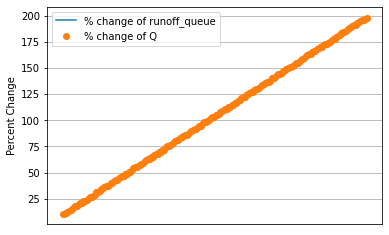

In [7]:
no_change = df.loc[df['Percent_Change'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change=float(no_change['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df['Mean_Streamflow']=100*df['Mean_Streamflow']//Q_at_no_change




# # # #df['Sum streamflow'][100]
# # # # df['Sum streamflow']#/Q_at_no_change
plt.plot(df['Percent_Change'],label='% change of runoff_queue', color='tab:blue')
plt.plot(df['Mean_Streamflow'], 'o', label='% change of Q', color = 'tab:orange')
plt.xticks([])
plt.ylabel('Percent Change')
plt.legend(loc=2)
plt.grid()
df.to_csv('C:\\Users\\zjbut\\Documents\\LookupTable.csv')

In [8]:
# Find mean streamflow to based changes on
# df_mean = df['Sum_streamflow'].mean()
#print('The Mean streamflow is %s' %(df_mean))

# If statement to add group to assocaited percent range 
df.loc[df['Percentage'] <=0.25,'Group'] = 1
df.loc[(df['Percentage'] > 0.25) & (df['Percentage'] <= 0.5),'Group'] = 2
df.loc[(df['Percentage'] > 0.5) & (df['Percentage'] <= 1.0),'Group'] = 3
df.loc[(df['Percentage'] > 1.0) & (df['Percentage'] <= 1.5),'Group'] = 4
df.loc[(df['Percentage'] > 1.5) & (df['Percentage'] <= 2.0),'Group'] = 5

# Test runoff
runoff_queue_m_per_timestep = 1
df.loc[(df['Group'] == 3), 'runoff_queue_m_per_timestep'] = runoff_queue_m_per_timestep * 0.1
#print(df)

KeyError: 'Percentage'